In [1]:
import os
import requests
import numpy as np
import pandas as pd
import vextract.svg
import vextract.filter
import vextract.convert
import svgpathtools as spt
import matplotlib.pyplot as plt
from pprint import pprint

from pathlib import Path

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# We need to download the article file.
# This article is not open access - a subscription is required.

URL = "https://www.nature.com/articles/s41586-020-2801-z.pdf"

if not Path('../data/source_data/s41586-020-2801-z.pdf').exists():
    print('Article file not found.  Attempting to download.')
    response = requests.get(URL)
    try:
        open('../data/source_data/s41586-020-2801-z.pdf', 'wb').write(response.content)
        print('Article successfully downloaded.')
    except OSError:
        print('Failed to download article.')
else:
    print('Article file found.')

Article file not found.  Attempting to download.
Article successfully downloaded.


In [3]:
# The un-edited paper: Nature volume 586, pages373–377 (2020).
paper_file = '../data/source_data/s41586-020-2801-z.pdf'

# Location to store the svg version of the relevant page.
svg_page_file = '../data/svg_files/CSH_page_2.svg'

# The page number on which the relavant figure is located.
# While it is page 2 of the pdf, this page is labeled as page 374.
page_number = 374

# Convert page 3 of the paper into an svg file.
os.system(f'pdf2svg {paper_file} {svg_page_file} {page_number}')

# Load the svg file into memory.
# The resulting structure is a tuple of two lists.
# The first is a list of the path objects.
# The second is a list of the corresponding attributes.
svg = (
    # Convert color codes to hex for convenience.
    vextract.convert.hexify(
        # load the file in a tuple of paths and attributes.
        spt.svg2paths(svg_page_file)))

In [4]:
# Here is an example of a data point from Run 2:
pprint(svg[0][30000])
pprint(svg[1][30000])

Path(CubicBezier(start=(208.292969+217.472656j), control1=(208.292969+218.171875j), control2=(207.726562+218.738281j), end=(207.03125+218.738281j)),
     CubicBezier(start=(207.03125+218.738281j), control1=(206.332031+218.738281j), control2=(205.765625+218.171875j), end=(205.765625+217.472656j)),
     CubicBezier(start=(205.765625+217.472656j), control1=(205.765625+216.777344j), control2=(206.332031+216.210938j), end=(207.03125+216.210938j)),
     CubicBezier(start=(207.03125+216.210938j), control1=(207.726562+216.210938j), control2=(208.292969+216.777344j), end=(208.292969+217.472656j)))
{'d': 'M 208.292969 217.472656 C 208.292969 218.171875 207.726562 218.738281 '
      '207.03125 218.738281 C 206.332031 218.738281 205.765625 218.171875 '
      '205.765625 217.472656 C 205.765625 216.777344 206.332031 216.210938 '
      '207.03125 216.210938 C 207.726562 216.210938 208.292969 216.777344 '
      '208.292969 217.472656 ',
 'style': ' stroke:none;fill-rule:evenodd;fill:#f05253;fill-opac

/tmp/ipykernel_450263/126165069.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(color_count_series.index, rotation = 90)


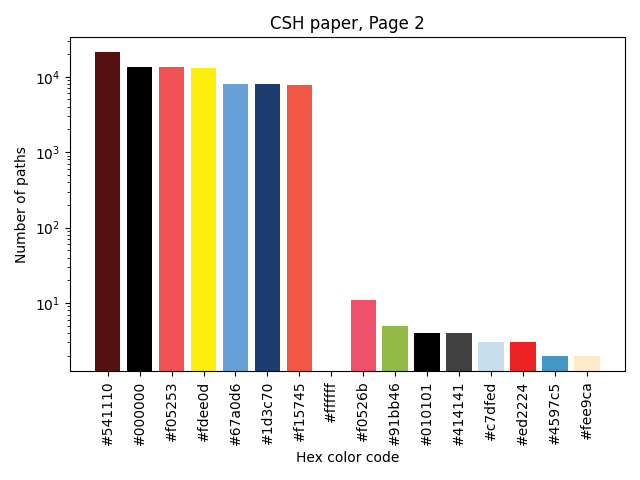

In [5]:
# This is a useful plot for figuring out colors that correspond to
# large numbers of data points.

fig, ax = plt.subplots()
color_count_series = vextract.svg.count_fill_colors(svg)
ax.bar(color_count_series.index, color_count_series, color=color_count_series.index, log=True)
ax.set_xticklabels(color_count_series.index, rotation = 90)
ax.set_xlabel('Hex color code')
ax.set_ylabel('Number of paths')
ax.set_title('CSH paper, Page 2')
fig.tight_layout()

In [6]:
# Selecting just the paths of the correct color with length 4
# and assigning them to the corresponding runs.
# Run 2 is plotted with two slightly different colors (hence a and b).
run1_dl = vextract.filter.by_fill(svg, '#67a0d6')
run2a_dl = vextract.filter.by_fill(svg, '#f05253')
run2b_dl = vextract.filter.by_fill(svg, '#f15745')
run3_dl = vextract.filter.by_fill(svg, '#fdee0d')

# Put these in a dictionary for convenient iterating.
dict_of_svgs = {
    'Run 1': run1_dl,
    'Run 2a': run2a_dl,
    'Run 2b': run2b_dl,
    'Run 3': run3_dl
}

In [7]:
# data_dict is a dictionary where the keys are the applied pressure and
# the values are the corresponding dataframes.

run_dict = {}
for run in dict_of_svgs:
    paths, attributes = dict_of_svgs[run]
    centers = []
    for path in paths:
        centers.append(vextract.svg.path_centroid(path))
    df = pd.DataFrame()
    df['x'] = [center[0] for center in centers]
    df['y'] = [center[1] for center in centers]
    run_dict[run] = df

In [8]:
# Here is what our data looks like at present.
display(run_dict['Run 1'])

,x,y
0,277.007812,68.666016
1,277.007812,68.716797
2,276.957031,68.716797
3,276.957031,68.767578
4,276.957031,68.818359
...,...,...
8017,471.589844,177.894531
8018,493.378906,166.457031
8019,500.390625,163.343750
8020,507.404296,149.820312


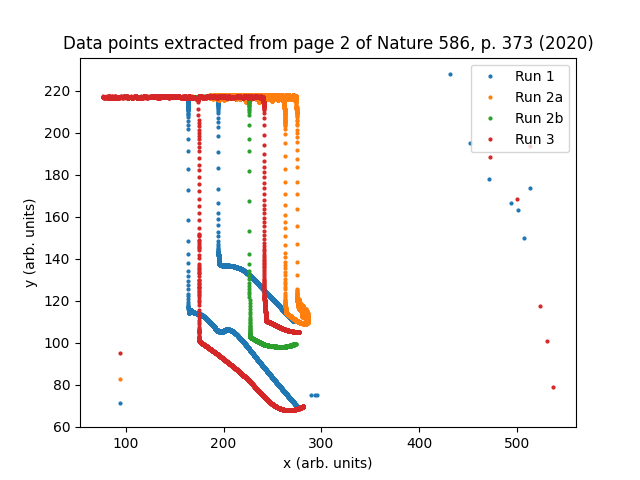

In [9]:
# Here is a plot showing all of the extracted data.
# The x and y axes are in arbitrary units of the svg file.
# In addition, we see some points from the legend and from Fig. 1b.
fig, ax = plt.subplots()
for run in run_dict:
    df = run_dict[run]
    ax.plot(df.x, df.y, 'o', label=run, markersize=2)
ax.set_xlabel('x (arb. units)')
ax.set_ylabel('y (arb. units)')
ax.set_title('Data points extracted from page 2 of Nature 586, p. 373 (2020)')
ax.legend()

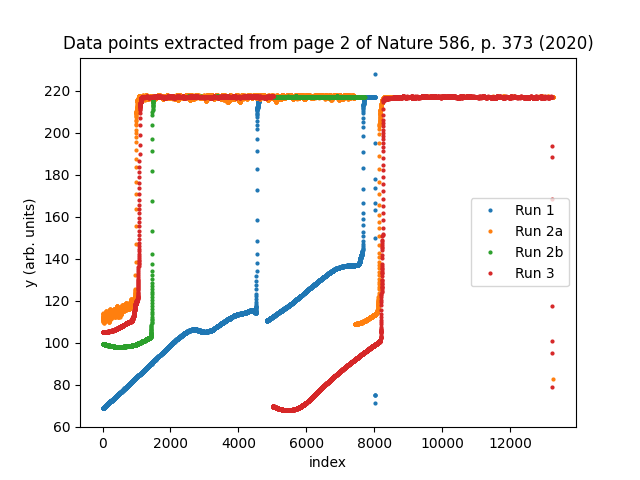

In [10]:
# In order to trim out the points from the legend and from Fig. 1b
# and also to divide the data into measurements at different pressures,
# it is helpful to make a plot showing the order in which the points appear.
fig, ax = plt.subplots()
for run in run_dict:
    df = run_dict[run]
    ax.plot(df.index, df.y, 'o', label=run, markersize=2)
ax.set_xlabel('index')
ax.set_ylabel('y (arb. units)')
ax.set_title('Data points extracted from page 2 of Nature 586, p. 373 (2020)')
ax.legend()

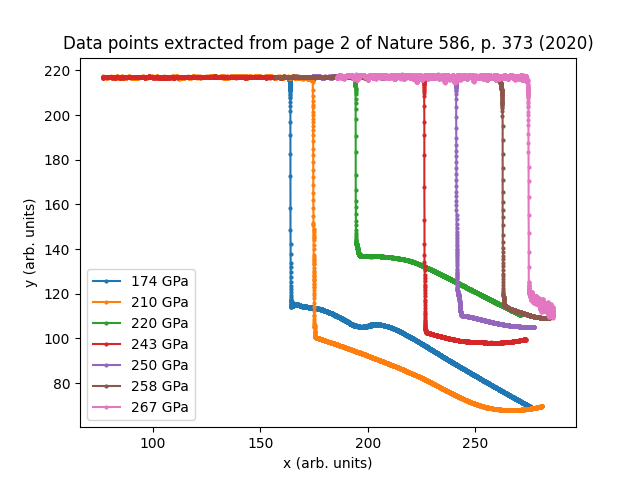

In [11]:
# Using the interactive feature of matplotlib in jupyter-lab on the 
# plot above, we can find the range of row numbers (index) that
# correspond to each measurement.
# We'll store the data in a dictionary with the pressure in GPa as key.

data_dict = {}

data_dict['174'] = run_dict['Run 1'][:4832].copy()
data_dict['210'] = run_dict['Run 3'][5015:13215].copy()
data_dict['220'] = run_dict['Run 1'][4832:8010].copy()
data_dict['243'] = run_dict['Run 2b'][:7710].copy()
data_dict['250'] = run_dict['Run 3'][:5014].copy()
data_dict['258'] = run_dict['Run 2a'][7417:13270].copy()
data_dict['267'] = run_dict['Run 2a'][:7416].copy()

fig, ax = plt.subplots()
for pressure in data_dict:
    df = data_dict[pressure]
    ax.plot(df.x, df.y, '-o', markersize=2, label=f'{pressure} GPa')
ax.set_xlabel('x (arb. units)')
ax.set_ylabel('y (arb. units)')
ax.set_title('Data points extracted from page 2 of Nature 586, p. 373 (2020)')
ax.legend()

In [12]:
'''
We have the data points, but we need to properly scale the
x and y axes.  The scale factors can be found by locating
the coordinates of the relevant x and y axis tick marks.

It appears some plotting software plots the tic marks as a
single path with multiple rectangles for each tic mark.
Looking at Fig. 1a, we can deduce the number of tic marks
for different axes.  Then we mutlipy the number of tic marks
by 4 to get the path length.  By filtering by color and path
length, we can find the svg path corresponding to the tic marks.
'''

y1_ticks = vextract.filter.by_fill_and_length(svg, '#000000', 52)[0]
x_ticks = vextract.filter.by_fill_and_length(svg, '#000000', 36)[0]
y2_ticks = vextract.filter.by_fill_and_length(svg, '#4597c5', 24)[0]

In [13]:
# Figuring out which paths correspond to the ticks as above takes some
# trial and error.  It's helpful to be able to display the svg paths inline
# as below.
vextract.svg.display_svg(x_ticks)

In [14]:
paths, attributes = svg

# This is the pathid for the x tic marks
# xmin corresponds to the x coordinate for 100 K (or maybe 300)
xmax = np.mean([item[0].real for item in x_ticks[0][0:4]])
xmin = np.mean([item[0].real for item in x_ticks[0][16:20]])

y1min = np.mean([item[0].imag for item in y1_ticks[0][0:4]])
y1max = np.mean([item[0].imag for item in y1_ticks[0][20:24]])

y2min = np.mean([item[0].imag for item in y2_ticks[0][0:4]])
y2max = np.mean([item[0].imag for item in y2_ticks[0][8:12]])

# scale_dict holds the information necessary to calibrate the axes scales.
scale_dict = {'x': (xmin, xmax),
              'y1': (y1min, y1max),
              'y2': (y2min, y2max)}

display(scale_dict)

{'x': (81.630859, 287.83203149999997),
 'y1': (68.3632815, 217.0859375),
 'y2': (86.183594, 216.93554699999999)}

In [15]:
'''
Extract the Fig 1a data from the svg file named <filename>.
return a dictionary of dataframes, where the key is the pressure
in GPa.

We also convert the x and y values to Temperature and Resistance.
'''

# Make an association between pressure and run number for Fig 1a
# We need this because the y-scale is different for Run 1, vs the
# other runs.
runs = {'174': 'Run 1',
        '220': 'Run 1',
        '243': 'Run 2',
        '258': 'Run 2',
        '267': 'Run 2',
        '210': 'Run 3',
        '250': 'Run 3'}

# Rescale the data to provide temperature and resistance columns.
for pressure in data_dict:
    df = data_dict[pressure]
    df['Temp'] = df['x'].apply(lambda x: vextract.svg.transform_coord(scale_dict['x'][0],
                                                                      scale_dict['x'][1],
                                                                      100.0,
                                                                      300.0,
                                                                      x))

    if runs[pressure] == 'Run 1':
        df['R'] = df['y'].apply(lambda y: vextract.svg.transform_coord(scale_dict['y2'][0],
                                                                       scale_dict['y2'][1],
                                                                       8.0,
                                                                       0,
                                                                       y))
    else:
        df['R'] = df['y'].apply(lambda y: vextract.svg.transform_coord(scale_dict['y1'][0],
                                                                       scale_dict['y1'][1],
                                                                       2.5,
                                                                       0,
                                                                       y))

In [16]:
# Now we have the data on a properly calibrated scale.
data_dict['267']

,x,y,Temp,R
0,286.530274,113.941406,298.737390,1.733840
1,286.530274,113.867188,298.737390,1.735088
2,286.530274,113.792969,298.737390,1.736335
3,286.530274,113.648438,298.737390,1.738765
4,286.530274,113.500000,298.737390,1.741260
...,...,...,...,...
7411,185.780273,216.522461,201.017286,0.009472
7412,185.780273,216.522461,201.017286,0.009472
7413,185.780273,216.887696,201.017286,0.003332
7414,185.780273,216.449219,201.017286,0.010703


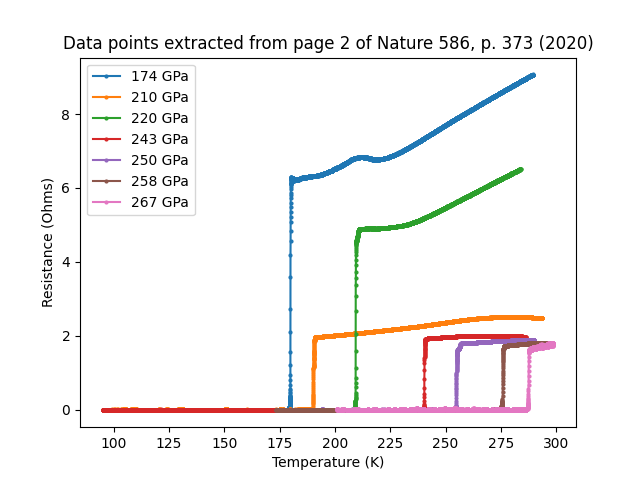

In [17]:
fig, ax = plt.subplots()
for pressure in data_dict:
    df = data_dict[pressure]
    ax.plot(df.Temp, df.R, '-o', markersize=2, label=f'{pressure} GPa')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Resistance (Ohms)')
ax.set_title('Data points extracted from page 2 of Nature 586, p. 373 (2020)')
ax.legend()

In [18]:
# Export the data to csv.

save_folder = '../data/extracted_data/CSH-Fig1a'

for pressure in data_dict:
    df = data_dict[pressure]
    df.to_csv(f'{save_folder}/{pressure}_GPa.csv', index=False)